<a href="https://colab.research.google.com/github/ToanToan110/project1/blob/main/BaseMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **Lĩnh vực Growth Hacking - phân tích tăng trưởng có rất nhiều Metric cốt lỗi mà doanh nghiệp có thể mang đến cho khách hàng, những metric  mà ta cần quan tâm như RFM, Retenrate, Cohort...
**

In [ ]:
import pandas as pd
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/OnlineRetail.csv", encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Doanh thu theo từng tháng

In [ ]:
# @title Clean data
df.rename({'InvoiceDate':'InvoiceDatetime'}, axis = 1, inplace=True)
df['InvoiceDatetime'] = pd.to_datetime(df['InvoiceDatetime'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDatetime'].dt.strftime('%Y-%m-%d'))
df['InvoiceMonth'] = df['InvoiceDatetime'].map(lambda date: 100*date.year + date.month)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        541909 non-null  object        
 1   StockCode        541909 non-null  object        
 2   Description      540455 non-null  object        
 3   Quantity         541909 non-null  int64         
 4   InvoiceDatetime  541909 non-null  datetime64[ns]
 5   UnitPrice        541909 non-null  float64       
 6   CustomerID       406829 non-null  float64       
 7   Country          541909 non-null  object        
 8   InvoiceDate      541909 non-null  datetime64[ns]
 9   InvoiceMonth     541909 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 41.3+ MB


In [ ]:
# df['InvoiceMonth'] = df['InvoiceDatetime'].map(lambda date: 100*date.year + date.month).astype(str)

# I. Expandatory Analysis

In [ ]:
df['Revenue'] = df['UnitPrice'] * df['Quantity']
df_group_by_month = df.groupby('InvoiceMonth')['Revenue'].sum()
# df_group_by_month.plot(kind='line', x='InvoiceMonth', y='Revenue', color='#007bff')
px.line(df_group_by_month, title = 'Total Revenue by Month')

In [ ]:
#using pct_change() function to see monthly percentage change
df_group_by_month = pd.DataFrame(df_group_by_month, columns = ['Revenue']).reset_index()
df_group_by_month['MonthlyGrowth'] = df_group_by_month['Revenue'].pct_change()
px.line(df_group_by_month,
        x = df_group_by_month['InvoiceMonth'],
        y = df_group_by_month['MonthlyGrowth'],
        title = 'Percentage change by Month' )

**Nhận xét**:
- Tháng 4 của năm 2011 có doanh thu giảm so với giai đoạn trước đó (27.8%)

In [ ]:
#creating a new dataframe with UK customers only
tx_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

<Axes: title={'center': 'Unique Customer per Month'}>

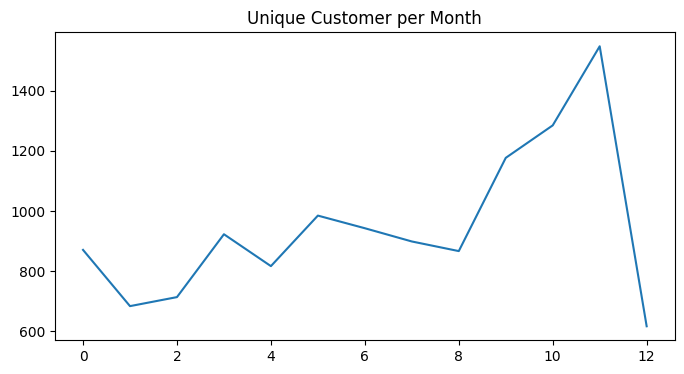

In [ ]:
# @title Customer by Month

#creating monthly active customers dataframe by counting unique Customer IDs
tx_monthly_active = tx_uk.groupby('InvoiceMonth')['CustomerID'].nunique().reset_index()
from matplotlib import pyplot as plt
tx_monthly_active['CustomerID'].plot(kind='line', figsize=(8, 4), title='Unique Customer per Month')

=> Số lượng khách hàng giảm vào tháng 4 và tháng 12

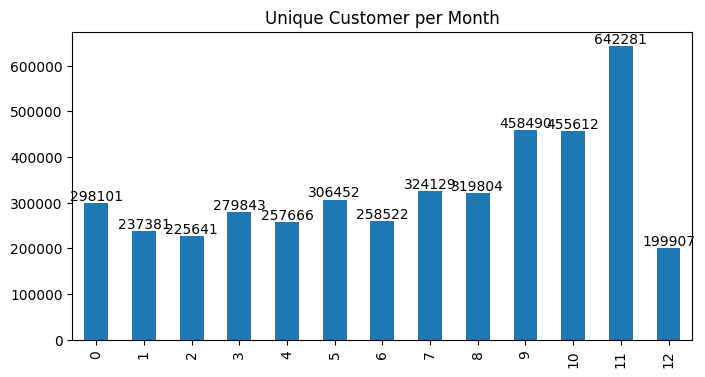

In [ ]:
# @title Number of Order by Month
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_order = tx_uk.groupby('InvoiceMonth')['Quantity'].sum().reset_index()
from matplotlib import pyplot as plt
ax = df_monthly_order['Quantity'].plot(kind='bar', figsize=(8, 4), title='Unique Customer per Month')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height(), str(round(i.get_height(), 2)), ha='center', va='bottom')

=> First: ***Quantity of product*** (số lượng bán ra) cũng giảm vào tháng 4 và tháng 12

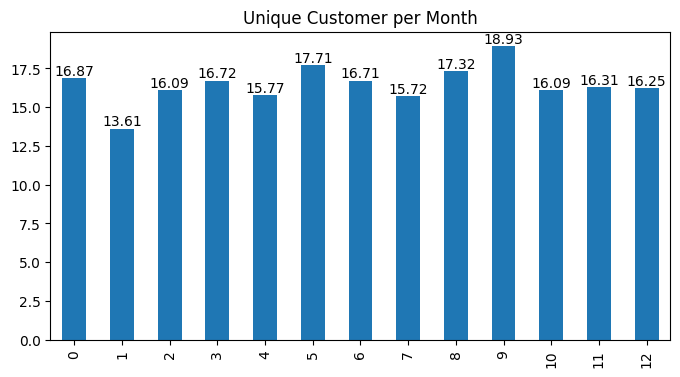

In [ ]:
# @title Average Revenue by Month
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_order = tx_uk.groupby('InvoiceMonth')['Revenue'].mean().reset_index()
from matplotlib import pyplot as plt
ax = df_monthly_order['Revenue'].plot(kind='bar', figsize=(8, 4), title='Unique Customer per Month')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height(), str(round(i.get_height(), 2)), ha='center', va='bottom')

=> Doanh thu trung bình của tháng 4 và tháng 12 theo đó cũng giảm

# II.Analyze base on Metric

## New User Analysis

---
New User (khách hàng mới): Khách hàng thực hiện lần mua hàng đầu tiên trong một khoảng thời gian xác định



In [ ]:
tx_min_purchase = tx_uk.groupby("CustomerID")['InvoiceDate'].min().reset_index()
tx_min_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
tx_min_purchase

,CustomerID,MinPurchaseDate,MinPurchaseYearMonth
0,12346.0,2011-01-18,201101
1,12747.0,2010-12-05,201012
2,12748.0,2010-12-01,201012
3,12749.0,2011-05-10,201105
4,12820.0,2011-01-17,201101
...,...,...,...
3945,18280.0,2011-03-07,201103
3946,18281.0,2011-06-12,201106
3947,18282.0,2011-08-05,201108
3948,18283.0,2011-01-06,201101


In [ ]:
tx_uk = pd.merge(tx_uk, tx_min_purchase, on='CustomerID')
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDatetime,UnitPrice,CustomerID,Country,InvoiceDate,InvoiceMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,201012,15.30,2010-12-01,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,201012,20.34,2010-12-01,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,201012,22.00,2010-12-01,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,201012,20.34,2010-12-01,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,201012,20.34,2010-12-01,201012


In [ ]:
# @title New/Old user by Month
tx_uk.InvoiceMonth = tx_uk.InvoiceMonth.astype(int)
tx_uk['UserType'] = 'New'
tx_uk.loc[tx_uk['InvoiceMonth'] > tx_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'
tx_uk.loc[tx_uk['UserType'] == 'Existing']

#calculate the Revenue per month for each user type
tx_user_type_revenue = tx_uk.groupby(['InvoiceMonth','UserType'])['Revenue'].sum().reset_index()

#filtering the dates and plot the result
tx_user_type_revenue = tx_user_type_revenue.query("InvoiceMonth != 201012 and InvoiceMonth != 201112")
plot_data = [
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceMonth'],
        y=tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'New'")['InvoiceMonth'],
        y=tx_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

<Axes: >

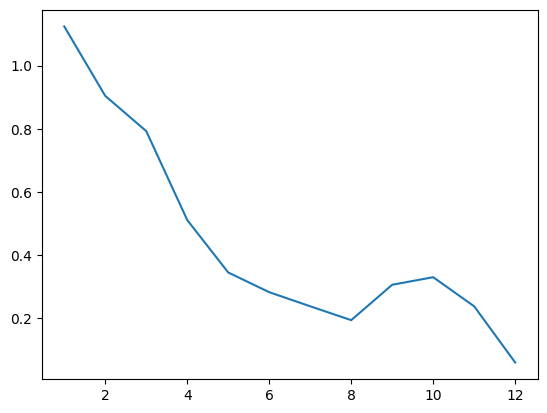

In [ ]:
# @title New/Old user rate
new_user_by_month = tx_uk.query("UserType == 'New'").groupby(['InvoiceMonth'])['CustomerID'].nunique()
old_user_by_month = tx_uk.query("UserType == 'Existing'").groupby(['InvoiceMonth'])['CustomerID'].nunique()
tx_user_ratio = (new_user_by_month/old_user_by_month).reset_index()
tx_user_ratio = tx_user_ratio.dropna()
tx_user_ratio['CustomerID'].plot(kind ='line')

=> Tỉ lệ khách hàng mới cũng giảm vào tháng 4 và đặc biệt là tháng 12

## Retention rate
---




> **Formula:**
Retained Customer from lastmonth / Current Active Customer




In [ ]:
#identify which users are active by looking at their revenue per month
tx_user_purchase = tx_uk.groupby(['CustomerID','InvoiceMonth'])['Revenue'].sum().reset_index()
#create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceMonth']).reset_index()
tx_retention.head()

InvoiceMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


<Axes: title={'center': 'RetentionRate'}>

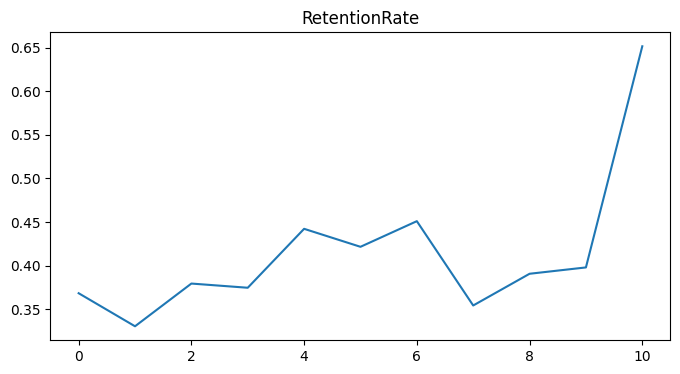

In [ ]:
#create an array of dictionary which keeps Retained & Total User count for each month
months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)

#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']
tx_retention
tx_retention['RetentionRate'].plot(kind='line', figsize=(8, 4), title='RetentionRate')

## Cohort Analysis

In [ ]:
#create our retention table again with crosstab() and add firs purchase year month view
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceMonth']).reset_index()
tx_retention = pd.merge(tx_retention,tx_min_purchase[['CustomerID','MinPurchaseYearMonth']],on='CustomerID')
tx_retention
new_column_names = [ 'm_' + str(column) for column in tx_retention.columns[:-1]]
new_column_names.append('MinPurchaseYearMonth')
tx_retention.columns = new_column_names
tx_retention

,m_CustomerID,m_201012,m_201101,m_201102,m_201103,m_201104,m_201105,m_201106,m_201107,m_201108,m_201109,m_201110,m_201111,m_201112,MinPurchaseYearMonth
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0,201101
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1,201012
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1,201012
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1,201105
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1,201101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,18280.0,0,0,0,1,0,0,0,0,0,0,0,0,0,201103
3946,18281.0,0,0,0,0,0,0,1,0,0,0,0,0,0,201106
3947,18282.0,0,0,0,0,0,0,0,0,1,0,0,0,1,201108
3948,18283.0,0,1,1,0,1,1,1,1,0,1,1,1,1,201101


In [ ]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan

    total_user_count = tx_retention[tx_retention.MinPurchaseYearMonth ==  selected_month].MinPurchaseYearMonth.count()
    retention_data['TotalUserCount'] = total_user_count ## Khách hàng mua hàng lần đầu tiên tại tháng đang xét
    retention_data[selected_month] = np.nan

    query = "MinPurchaseYearMonth == {}".format(selected_month)


    for next_month in next_months:
        new_query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(tx_retention.query(new_query)['m_' + str(next_month)].sum()/total_user_count,3)
    retention_array.append(retention_data)

tx_retention = pd.DataFrame(retention_array)
tx_retention.index = months

#showing new cohort based retention table
tx_retention

,TotalUserCount,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
InvoiceMonth,,,,,,,,,,,,,
201101,362,NaN,0.232,0.279,0.246,0.343,0.293,0.262,0.260,0.315,0.351,0.362,0.149
201102,339,NaN,NaN,0.251,0.192,0.280,0.283,0.254,0.260,0.283,0.277,0.313,0.097
201103,408,NaN,NaN,NaN,0.194,0.262,0.216,0.233,0.172,0.262,0.238,0.292,0.093
201104,276,NaN,NaN,NaN,NaN,0.225,0.221,0.217,0.207,0.232,0.232,0.264,0.083
201105,252,NaN,NaN,NaN,NaN,NaN,0.230,0.171,0.171,0.214,0.238,0.266,0.099
201106,207,NaN,NaN,NaN,NaN,NaN,NaN,0.213,0.164,0.246,0.256,0.324,0.097
201107,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203,0.192,0.233,0.279,0.110
201108,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.264,0.229,0.257,0.136
201109,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291,0.327,0.120


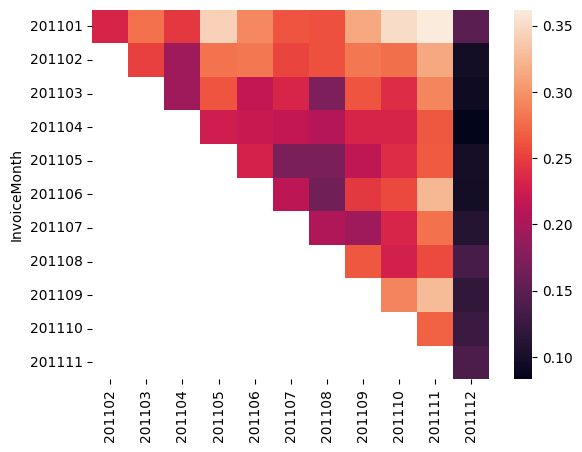

In [ ]:
retention_chart = tx_retention.reset_index()
retention_chart = tx_retention.iloc[:-1,2:]
ax = sns.heatmap(retention_chart)

=> Rõ ràng dựa vào dataset, ta thấy được nhiều vấn đề tiêu cực của doanh nghiệp vào tháng 4 và tháng 12 năm 2011.

Core metric định hướng cho doanh nghiệp deepdive tìm ra vấn đề của mình và đánh giá performance một cách trực quan nhất